In [1]:
import datetime
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported using device_map="cpu"
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [2]:
df = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv")
df["id"] = df["item_id"] + "_" + df["store_id"]
df = df[["id", ] + [cn for cn in df.columns if cn.startswith("d_")]]

df = df.melt(id_vars="id", var_name="timestamp", value_name="value")
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

df

,id,timestamp,value
0,HOBBIES_1_001_CA_1,2011-01-29,0
1,HOBBIES_1_002_CA_1,2011-01-29,0
2,HOBBIES_1_003_CA_1,2011-01-29,0
3,HOBBIES_1_004_CA_1,2011-01-29,0
4,HOBBIES_1_005_CA_1,2011-01-29,0
...,...,...,...
58327365,FOODS_3_823_WI_3,2016-04-24,1
58327366,FOODS_3_824_WI_3,2016-04-24,0
58327367,FOODS_3_825_WI_3,2016-04-24,0
58327368,FOODS_3_826_WI_3,2016-04-24,3


In [3]:
test_df = pd.read_csv("m5-forecasting-accuracy/sales_train_evaluation.csv")
test_df["id"] = test_df["item_id"] + "_" + test_df["store_id"]
test_df = test_df[test_df["id"].isin(df["id"].unique())]
test_df = test_df[["id", ] + [cn for cn in test_df.columns if cn.startswith("d_")]]
test_df = test_df.melt(id_vars="id", var_name="timestamp", value_name="value")

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

test_df

,id,timestamp,value
0,HOBBIES_1_001_CA_1,2011-01-29,0
1,HOBBIES_1_002_CA_1,2011-01-29,0
2,HOBBIES_1_003_CA_1,2011-01-29,0
3,HOBBIES_1_004_CA_1,2011-01-29,0
4,HOBBIES_1_005_CA_1,2011-01-29,0
...,...,...,...
59181085,FOODS_3_823_WI_3,2016-05-22,1
59181086,FOODS_3_824_WI_3,2016-05-22,0
59181087,FOODS_3_825_WI_3,2016-05-22,2
59181088,FOODS_3_826_WI_3,2016-05-22,0


In [4]:
train_inputs = []
for item_id, group in df.groupby("id"):
    train_inputs.append({
        "target": group["value"].values,
    })

In [5]:
# Fine-tune the model by default full fine-tuning will be performed
finetuned_pipeline = pipeline.fit(
    inputs=train_inputs,
    prediction_length=28,
    num_steps=1_000,
    learning_rate=1e-4,
    batch_size=128,
    logging_steps=100,
    finetune_mode="lora",
)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
100,4.960500
200,5.141200
300,5.072400
400,5.040500
500,5.040400
600,5.080000
700,4.992400
800,4.997600
900,4.953900
1000,5.058700


In [6]:



# Visualization helper function
def plot_forecast(
        context_df: pd.DataFrame,
        pred_df: pd.DataFrame,
        test_df: pd.DataFrame,
        target_column: str,
        timeseries_id: str,
        id_column: str = "id",
        timestamp_column: str = "timestamp",
        history_length: int = 256,
        title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

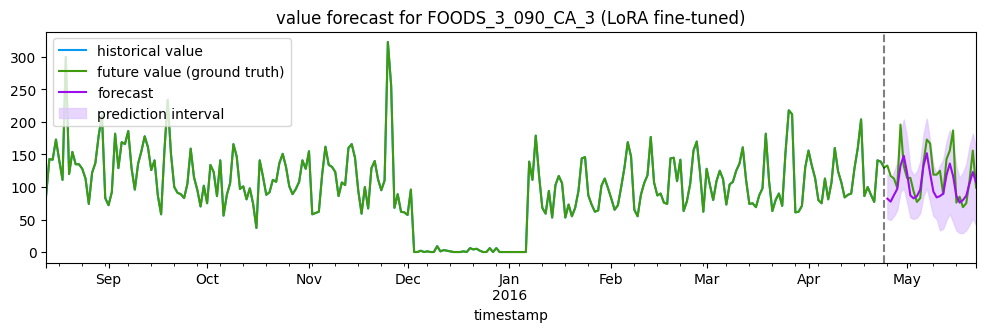

In [7]:
id = df.groupby("id")["value"].mean().idxmax()

# Use the fine-tuned model for predictions
finetuned_pred_df = finetuned_pipeline.predict_df(
    df,
    prediction_length=28,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column="id",
    timestamp_column="timestamp",
    target="value",
)

plot_forecast(
    df,
    finetuned_pred_df,
    test_df,
    target_column="value",
    timeseries_id=id,
    title_suffix="(LoRA fine-tuned)",
)

In [8]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

merged_df = finetuned_pred_df.merge(test_df, on=["id", "timestamp"], how="inner")

print(mean_absolute_scaled_error(merged_df["value"], merged_df["predictions"], y_train=df["value"]))

0.5252436483620258
